In [3]:
# Setup
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

DBUNAME = os.environ.get("DBUNAME")
DBPASSWORD = os.environ.get("DBPASSWORD")
DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBNAME = os.environ.get("DBNAME")

import sqlalchemy
import psycopg2

connection_str = 'postgresql+psycopg2://'+DBUNAME+':'+DBPASSWORD+'@'+DBHOST+':'+DBPORT+'/'+DBNAME

In [36]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib import rcParams

# What is the balance of trade for our countries of interest?
```
A priority should be to get Fiji & Vanuatu monthly/ quarterly GDP data and focus on one the Polynesian state (Kiribati) and one in Micronesia (Palau)?
That way, we’ll cover the three regions of the Pacific: 

(Fiji and Vanuatu = Melanesia (big exporters); 

Cook Islands and Kiribati = Polynesia (survive on imports); 

Palau = Micronesia (tourism represents around 40% of GDP and often employs a significant proportion of people in formal employment + 86% of its exports).
```

In [37]:
pd.read_sql("select distinct country from public.country_metrics where category = 'trade'",con=engine)

,country
0,pl
1,ki
2,sb
3,ws
4,fj
5,vn
6,ck


In [39]:
# are the countries available?
pd.read_sql(
"""
select country, frequency, name, min(date), max(date)
from public.country_metrics
where true
and category = 'trade'
-- and country in ('fj','vn','ck','ki','pw','sb')
and country = 'pl'
group by 1,2,3
order by 1,2,3
"""
,con=engine)

,country,frequency,name,min,max
0,pl,monthly,exports-fob-domestic,2018-01-01,2019-12-01
1,pl,monthly,exports-fob-reexport,2018-01-01,2019-12-01
2,pl,monthly,exports-fob-total,2018-01-01,2019-12-01
3,pl,monthly,imports-cif,2018-01-01,2019-12-01
4,pl,monthly,trade-balance,2018-01-01,2019-12-01


In [63]:
# analytics query
data_trade = pd.read_sql(
"""
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2019-12-01'
        )
        select 
            date
            ,region
            ,country
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3   
"""
,con=engine)
data_trade

,date,region,country,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio
0,2019-01-01,melanesia,fj,6.030260e+08,2.091587e+08,8.121847e+08,-3.938673e+08,0.346849
1,2019-01-01,melanesia,sb,3.243075e+08,3.937516e+08,7.180591e+08,6.944411e+07,1.214130
2,2019-01-01,melanesia,vn,2.714000e+09,4.090000e+08,3.123000e+09,-2.305000e+09,0.150700
3,2019-01-01,micronesia,pw,1.984973e+07,6.313747e+04,1.991287e+07,-1.978659e+07,0.003181
4,2019-01-01,polynesia,ck,1.005800e+07,1.780000e+06,1.183800e+07,-8.278000e+06,0.176974
...,...,...,...,...,...,...,...,...
58,2019-12-01,melanesia,fj,7.611194e+08,1.452798e+08,9.063992e+08,-6.158396e+08,0.190876
59,2019-12-01,melanesia,vn,4.454000e+09,5.800000e+08,5.034000e+09,-3.874000e+09,0.130220
60,2019-12-01,micronesia,pw,2.067773e+07,3.231236e+06,2.390897e+07,-1.744650e+07,0.156266
61,2019-12-01,polynesia,ck,2.235200e+07,1.424304e+06,2.377630e+07,-2.092770e+07,0.063722


In [59]:
with engine.connect() as con:
    con.execute("""
    drop table if exists public.stg_trade_agg;
    create table public.stg_trade_agg as 
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2019-12-01'
        )
        select 
            date
            ,region
            ,country
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3    
    ;;
    """)

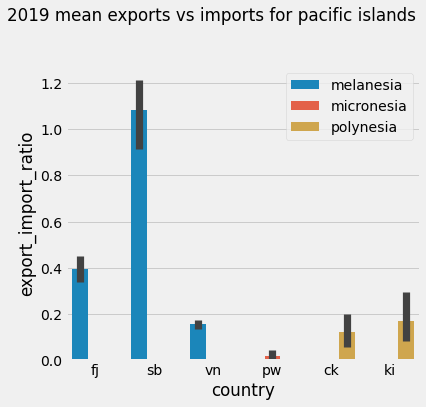

In [65]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(6,6))

sns.barplot(x='country',y='export_import_ratio',hue='region',data=data_trade)
plt.suptitle('2019 mean exports vs imports for pacific islands',x=0.01, y=.975,ha='left')
plt.legend(loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

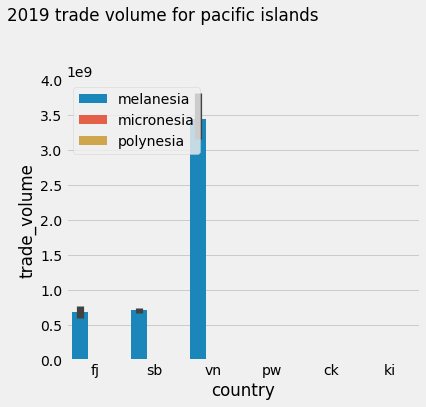

In [64]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(6,6))

sns.barplot(x='country',y='trade_volume',hue='region',data=data_trade)
plt.suptitle('2019 trade volume for pacific islands',x=0.01, y=.975,ha='left')
plt.legend(loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# How does AIS port calls compare to our balance of trade?

In [ ]:
# TBC

# Scratch

In [17]:
# are the countries available?
pd.read_sql(
"""
select distinct name, country
from public.country_metrics
where true
and category = 'trade'
and country in ('fj','vu','ck','ki','pw','sb')
order by 1
"""
,con=engine)

,name,country
0,exports-fob-domestic,fj
1,exports-fob-domestic,sb
2,exports-fob-domestic,ki
3,exports-fob-domestic,ck
4,exports-fob-reexport,sb
5,exports-fob-reexport,ki
6,exports-fob-reexport,ck
7,exports-fob-reexport,fj
8,exports-fob-total,ki
9,exports-fob-total,fj


In [15]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'CPI'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,CPI_2006_ALCOHOL/TOBACCO,kir,monthly,2018-01-01,2019-12-01
1,CPI_2006_ALL ITEMS,kir,monthly,2018-01-01,2019-12-01
2,CPI_2006_CLOTHING,kir,monthly,2018-01-01,2019-12-01
3,CPI_2006_EDUCATION & HEALTH,kir,monthly,2018-01-01,2019-12-01
4,CPI_2006_FOOD,kir,monthly,2018-01-01,2019-12-01
5,CPI_2006_HOUSEHOLD OPERATION,kir,monthly,2018-01-01,2019-12-01
6,CPI_2006_HOUSING,kir,monthly,2018-01-01,2019-12-01
7,CPI_2006_NON-ALCOHOLIC DRINKS,kir,monthly,2018-01-01,2019-12-01
8,CPI_2006_RECREATION,kir,monthly,2018-01-01,2019-12-01
9,CPI_2006_TRANSPORTATION,kir,monthly,2018-01-01,2019-12-01


In [16]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'tourism'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,arrivals-resident,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
1,arrivals-resident,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
2,arrivals-resident,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
3,arrivals-total,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
4,arrivals-total,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
5,arrivals-total,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
6,arrivals-visitor,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
7,arrivals-visitor,fj,monthly,2018-01-01 00:00:00,2020-06-01 00:00:00
8,arrivals-visitor,sb,quarterly,2016-01-01 00:00:00,2020-01-01 00:00:00
9,departures-resident,ck,monthly,2018-01-01 00:00:00,2020-03-01 00:00:00
